In [1]:
import uproot as ur
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set and select run information

run = [6,7,8][1] # the run number to analyze
channels = {6: [5], 7: [5], 8: [5]}[run] # the active PMT channels in this run
time_shifts = {6: np.arange(0., 5.5, 0.5),
               7: np.arange(0., 5.5, 0.5),
               8: np.arange(0., 5.5, 0.5)}[run]  # the time shift in each block of data
threshold = {6: 600, 7: 60, 8: 60}[run]  # the ADC threshold to consider a signal
period = {6: 100000, 7: 100000, 8: 100000}[run]  # the period of the LED flashes in ns
run_coarse_starts = {6: 47370, 7: 45490, 8: 46975}[run]  # the starting coarse time for the run (since previous data is included in the file)

print(f"Run {run}: channels = {channels}, time_shifts = [{', '.join(f'{ts:.2f}' for ts in time_shifts)}], threshold = {threshold}")


Run 7: channels = [5], time_shifts = [0.00, 0.50, 1.00, 1.50, 2.00, 2.50, 3.00, 3.50, 4.00, 4.50, 5.00], threshold = 60


In [3]:
# Load the ROOT file and access the tree
file_path = f'run{run:03d}.root'
data_file = ur.open(file_path)

In [4]:
# check top level keys
data_file.keys()

['led_events;1', 'pmt_events;1']

In [5]:
# list keys in the pmt_events tree
print([key for key in list(data_file['pmt_events'].keys())])

['event_type', 'channel', 'status', 'length', 'adc', 'pmt_time', 'time_coarse', 'time_fine', 'tdc_coarse', 'tdc_start', 'tdc_stop', 'tot', 'crc']


In [6]:
# Create numpy arrays for each branch of interest

adc_values = data_file['pmt_events']['adc'].array(library='np').flatten()
tot_values = data_file['pmt_events']['tot'].array(library='np').flatten()
channel_values = data_file['pmt_events']['channel'].array(library='np').flatten()
pmt_time_values = data_file['pmt_events']['pmt_time'].array(library='np').flatten()
time_coarse_values = data_file['pmt_events']['time_coarse'].array(library='np').flatten()
time_fine_values = data_file['pmt_events']['time_fine'].array(library='np').flatten()
tdc_start_values = data_file['pmt_events']['tdc_start'].array(library='np').flatten()

data = {
    'adc': adc_values,
    'tot': tot_values,
    'channel': channel_values,
    'pmt_time': pmt_time_values,
    'time_coarse': time_coarse_values,
    'time_fine': time_fine_values,
    'tdc_start': tdc_start_values}

In [7]:
# Check properties of the data arrays

for key, array in data.items():
    print(f'{key}: shape={array.shape}, len={len(array)}, min={np.min(array)}, max={np.max(array)}, mean={np.mean(array)}, std={np.std(array)}, type={array.dtype}')

# Confirm meaning of the time data:
# time_coarse: 16 bit unsigned int, counts of 2^28 * 4 ns clock -> LSB = 1.07 s
# time_fine: 32 bit unsigned int, counts of 4 ns clock -> LSB = 4 ns (only lower 28 bits used)
# pmt_time: 32 bit unsigned int, time_coarse * 2^28 + time_fine, counts of 4 ns clock -> LSB = 4 ns
# tdc_start: 4 bit unsigned int, counts of 0.25 ns clock -> LSB = 0.25 ns

check_pmt_time_values = np.uint64(time_coarse_values) * (2**28) + time_fine_values
# Check that pmt_time matches calculated value
if np.array_equal(pmt_time_values, check_pmt_time_values):
    print("pmt_time matches calculated value from time_coarse and time_fine")
else:
    print("pmt_time does NOT match calculated value from time_coarse and time_fine")


adc: shape=(537210,), len=537210, min=108, max=4095, mean=468.6937138176877, std=128.37163575692196, type=uint16
tot: shape=(537210,), len=537210, min=0.75, max=239.75, mean=11.965560913085938, std=6.049129962921143, type=float32
channel: shape=(537210,), len=537210, min=5, max=5, mean=5.0, std=0.0, type=uint16
pmt_time: shape=(537210,), len=537210, min=12196046400138, max=12359242409867, mean=12285409136900.713, std=43096908347.19386, type=uint64
time_coarse: shape=(537210,), len=537210, min=45433, max=46041, mean=45766.21453063048, std=160.54910618927067, type=uint16
time_fine: shape=(537210,), len=537210, min=251, max=268435211, mean=134469977.09645203, std=77359759.87549001, type=uint32
tdc_start: shape=(537210,), len=537210, min=0, max=15, mean=7.3342826827497625, std=4.372282976602705, type=uint16
pmt_time matches calculated value from time_coarse and time_fine


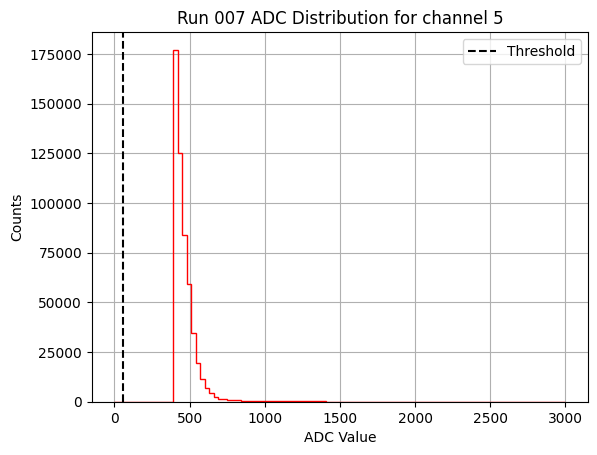

In [8]:
# plot adc distribution for the first active channel
ic = 0
mask = (channel_values == channels[ic])
plt.hist(adc_values[mask], bins=100, range=(0, 3000), histtype='step', color='red')
# overlay a vertical line for the threshold
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.legend()
#plt.yscale('log')
plt.xlabel('ADC Value')
plt.ylabel('Counts')
plt.title(f'Run {run:03d} ADC Distribution for channel {channels[ic]}')
plt.grid(True)
plt.savefig(f'img/adc_distribution_run{run:03d}_chan{channels[ic]:02d}.png')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


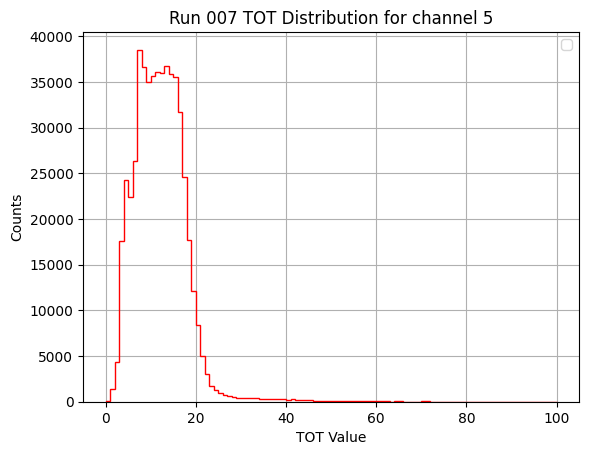

In [9]:
# plot tot distribution for the first active channel
ic = 0
mask = (channel_values == channels[ic])
plt.hist(tot_values[mask], bins=100, range=(0, 100), histtype='step', color='red')
# overlay a vertical line for the threshold
# plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.legend()
#plt.yscale('log')
plt.xlabel('TOT Value')
plt.ylabel('Counts')
plt.title(f'Run {run:03d} TOT Distribution for channel {channels[ic]}')
plt.grid(True)
plt.savefig(f'img/tot_distribution_run{run:03d}_chan{channels[ic]:02d}.png')
plt.show()

Coarse Time Range: 45433 to 46041


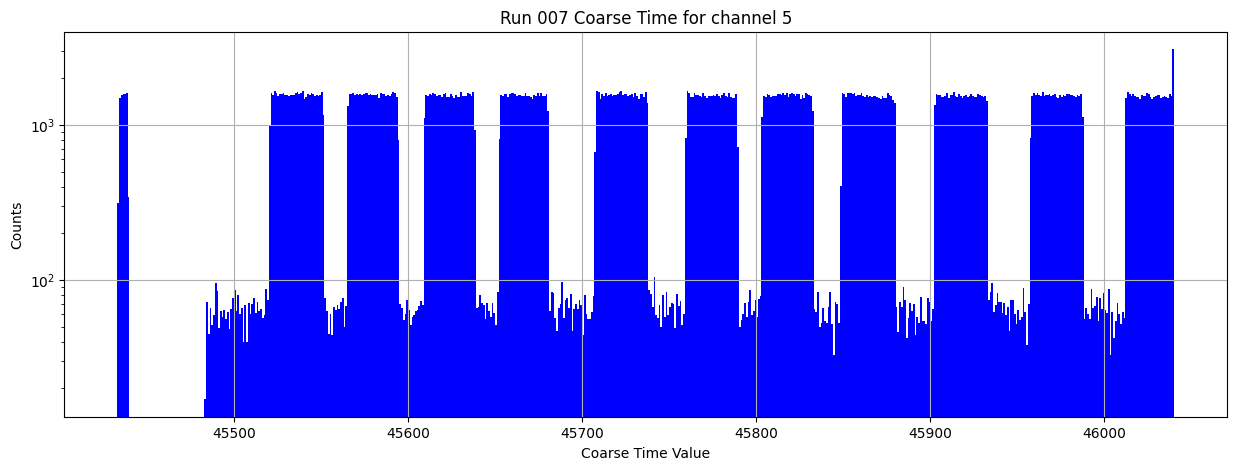

In [10]:
# plot the coarse time distribution
ic = 0
mask = (channel_values == channels[ic])

time_coarse_min = np.min(time_coarse_values[mask])
time_coarse_max = np.max(time_coarse_values[mask])
print(f"Coarse Time Range: {time_coarse_min} to {time_coarse_max}")

# make the plot wider
plt.figure(figsize=(15, 5))
plt.hist(time_coarse_values[mask], bins=np.arange(time_coarse_min,time_coarse_max,1), color='blue')
plt.yscale('log')
plt.xlabel('Coarse Time Value')
plt.ylabel('Counts')
plt.title(f'Run {run:03d} Coarse Time for channel {channels[ic]}')
plt.grid(True)
plt.savefig(f'img/coarse_time_distribution_run{run:03d}_chan{channels[ic]:02d}.png')
plt.show()


In [11]:
# The data were taken in blocks with different time shifts as specified in time_shifts.
# The blocks are clearly separated in the coarse time distribution with a very small number of entries in between.

# Look at the number of entries for each time_coarse value
unique, counts = np.unique(time_coarse_values[time_coarse_values>run_coarse_starts], return_counts=True)
min_rate = 400

# A new block is indicated when the count for previous coarse time value is less than min_rate (=400) and the count for
# the current coarse time value is greater than min_rate. Likewise the block ends when the count for the current
# coarse time value is greater than min_rate and the count for the next coarse time value is less than min_rate.

# Also define the off blocks, that are the regions with counts less than min_rate between the blocks, and 2 coarse times from the block edges

block_starts = []
block_ends = []
off_starts = []
off_ends = []

off_starts = [unique[0]+2]
led='off'
for i in range(1, len(unique)-1):
    if counts[i-1] < min_rate and counts[i] > min_rate:
        block_starts.append(unique[i]+1)
        off_ends.append(unique[i]-2)
        led='on'
    if counts[i] > min_rate and counts[i+1] < min_rate:
        block_ends.append(unique[i]-1)
        off_starts.append(unique[i]+2)
        led='off'
if led=='on':
    block_ends.append(unique[-1]-1)
else:
    off_ends.append(unique[-1]-2)

# Check that the number of time shifts matches the number of blocks found
if len(block_starts) != len(time_shifts) or len(block_ends) != len(time_shifts):
    print(f"Warning: number of blocks found ({len(block_starts)}) does not match number of time shifts ({len(time_shifts)})")

# Print summary: block number, time_shift, start, end, number of entries
for i, (start, end) in enumerate(zip(block_starts, block_ends)):
    num_entries = np.sum((time_coarse_values >= start) & (time_coarse_values <= end))
    print(f"Block {i}: time_shift = {time_shifts[i]}, Start = {start}, End = {end}, Number of Entries = {num_entries}")

# Print summary: led_off number, time_shift, start, end, number of entries
for i, (start, end) in enumerate(zip(off_starts, off_ends)):
    num_entries = np.sum((time_coarse_values >= start) & (time_coarse_values <= end))
    print(f"LED_off {i}: Start = {start}, End = {end}, Number of Entries = {num_entries}")


Block 0: time_shift = 0.0, Start = 45521, End = 45550, Number of Entries = 47382
Block 1: time_shift = 0.5, Start = 45566, End = 45593, Number of Entries = 44102
Block 2: time_shift = 1.0, Start = 45610, End = 45637, Number of Entries = 43617
Block 3: time_shift = 1.5, Start = 45653, End = 45679, Number of Entries = 42048
Block 4: time_shift = 2.0, Start = 45708, End = 45736, Number of Entries = 45605
Block 5: time_shift = 2.5, Start = 45760, End = 45788, Number of Entries = 44939
Block 6: time_shift = 3.0, Start = 45804, End = 45831, Number of Entries = 43617
Block 7: time_shift = 3.5, Start = 45849, End = 45878, Number of Entries = 46378
Block 8: time_shift = 4.0, Start = 45903, End = 45931, Number of Entries = 44836
Block 9: time_shift = 4.5, Start = 45958, End = 45986, Number of Entries = 45196
Block 10: time_shift = 5.0, Start = 46013, End = 46040, Number of Entries = 43110
LED_off 0: Start = 45493, End = 45518, Number of Entries = 1675
LED_off 1: Start = 45553, End = 45563, Numbe

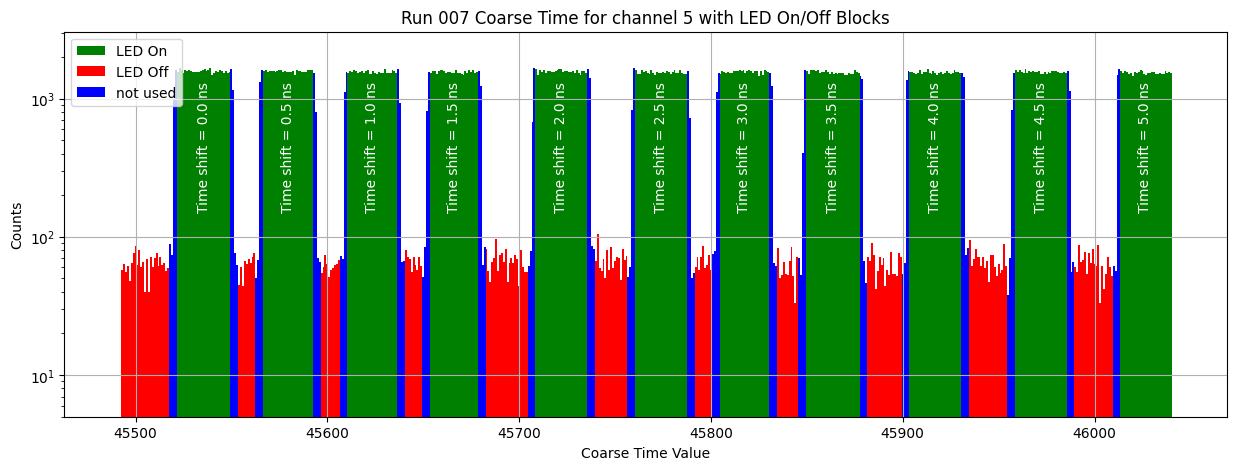

In [12]:
# plot the coarse time distribution
ic = 0
mask = (channel_values == channels[ic])

# Histogram the coarse time distribution by color: green inside the blocks, red outside the blocks, and white in between
# Label the blocks with their time shifts

unique, counts = np.unique(time_coarse_values[time_coarse_values>run_coarse_starts], return_counts=True)

# sort the unique and counts by unique, in case they are not sorted
order = np.argsort(unique)
unique = unique[order]
counts = counts[order]

bins = np.arange(unique[0], unique[-1], 1)

plt.figure(figsize=(15, 5))

counts_on = np.array([0.01]*len(unique))
for start, end in zip(block_starts, block_ends):
    mask_on = (unique >= start) & (unique <= end)
    counts_on[mask_on] = counts[mask_on]

counts_off = np.array([0.01]*len(unique))
for start, end in zip(off_starts, off_ends):
    mask_off = (unique >= start) & (unique <= end)
    counts_off[mask_off] = counts[mask_off]

counts_between = np.array([0.01]*len(unique))
for start, end in zip(off_ends, block_starts):
    if start < end and (end-start) < 10:
        mask_between = (unique >= start) & (unique <= end)
        counts_between[mask_between] = counts[mask_between]
for start, end in zip(block_ends, off_starts[1:]):
    if start < end and (end-start) < 10:
        mask_between = (unique >= start) & (unique <= end)
        counts_between[mask_between] = counts[mask_between]

plt.bar(unique, counts_on, width=1, color='green', label='LED On')
plt.bar(unique, counts_off, width=1, color='red', label='LED Off')
plt.bar(unique, counts_between, width=1, color='blue', label='not used')

plt.yscale('log')
plt.ylim(bottom=5.)
plt.xlabel('Coarse Time Value')
plt.ylabel('Counts')
plt.title(f'Run {run:03d} Coarse Time for channel {channels[ic]} with LED On/Off Blocks')
# add text labels for each block
for i, (start, end) in enumerate(zip(block_starts, block_ends)):
    plt.text((start+end)/2, max(counts)*0.8, f'Time shift = {time_shifts[i]} ns', color='white', ha='center', va='top', fontsize=10, rotation=90)
plt.legend()
plt.grid(True)
plt.savefig(f'img/coarse_time_distribution_blocks_run{run:03d}_chan{channels[ic]:02d}.png')
plt.show()

Total LED On Duration: 315, Total LED Off Duration: 191, Time Ratio (On/Off): 1.649
Ratio of counts in most populated bin (bin 13, ADC range 390.0-420.0) LED On to LED Off (scaled): 20.510


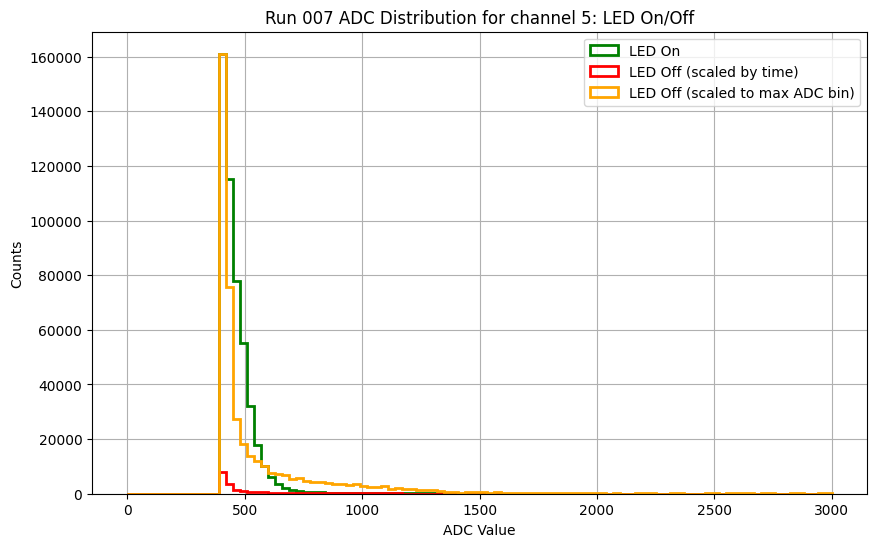

In [13]:
# Histogram the ADC values for the blocks with LED off and with LED on. Rescale the off blocks by the total time duration ratio.

hist_bins = 100
hist_range = (0, 3000)

# Calculate the total time duration for on and off blocks. Note that the block starts and ends are in coarse time units (2^28 * 4 ns = 1.07 s) and the blocks include the endpoints.
total_on_duration = 0
for start, end in zip(block_starts, block_ends):
    total_on_duration += (end - start + 1)
total_off_duration = 0
for start, end in zip(off_starts, off_ends):
    total_off_duration += (end - start + 1)
time_ratio = total_on_duration / total_off_duration
print(f'Total LED On Duration: {total_on_duration}, Total LED Off Duration: {total_off_duration}, Time Ratio (On/Off): {time_ratio:.3f}')

# plot the adc distributions for on and off blocks
ic = 0  # channel index to plot
plt.figure(figsize=(10, 6))
# LED on blocks
mask_on = np.zeros_like(adc_values, dtype=bool)
for start, end in zip(block_starts, block_ends):
    mask_on |= (time_coarse_values >= start) & (time_coarse_values <= end)
plt.hist(adc_values[mask_on & (channel_values == channels[ic])], bins=hist_bins, range=hist_range, histtype='step', lw=2, color='green', label='LED On')
# LED off blocks
mask_off = np.zeros_like(adc_values, dtype=bool)
for start, end in zip(off_starts, off_ends):
    mask_off |= (time_coarse_values >= start) & (time_coarse_values <= end)
plt.hist(adc_values[mask_off & (channel_values == channels[ic])], bins=hist_bins, range=hist_range, histtype='step', lw=2, color='red', label='LED Off (scaled by time)', weights=np.full(np.sum(mask_off & (channel_values == channels[ic])), time_ratio))

# Calculate the radio of counts in the most populated bin in the LED on histogram to the LED off histogram in the same bin
# Get the histogram data
counts_on, bin_edges_on = np.histogram(adc_values[mask_on & (channel_values == channels[ic])], bins=hist_bins, range=hist_range)
counts_off, bin_edges_off = np.histogram(adc_values[mask_off & (channel_values == channels[ic])], bins=hist_bins, range=hist_range)
max_bin_index = np.argmax(counts_on)
if counts_off[max_bin_index] > 0:
    ratio_max_bin = counts_on[max_bin_index] / (counts_off[max_bin_index] * time_ratio)
    print(f'Ratio of counts in most populated bin (bin {max_bin_index}, ADC range {bin_edges_on[max_bin_index]}-{bin_edges_on[max_bin_index+1]}) LED On to LED Off (scaled): {ratio_max_bin:.3f}')

    # Now show the LED off histogram scaled by ratio_max_bin
    plt.hist(adc_values[mask_off & (channel_values == channels[ic])], bins=hist_bins, range=hist_range, histtype='step', lw=2, color='orange', label='LED Off (scaled to max ADC bin)', weights=np.full(np.sum(mask_off & (channel_values == channels[ic])), time_ratio * ratio_max_bin))

else:
    print(f'No counts in LED Off histogram in most populated bin of LED On histogram (bin {max_bin_index}, ADC range {bin_edges_on[max_bin_index]}-{bin_edges_on[max_bin_index+1]})')

plt.legend()
#plt.yscale('log')
plt.xlabel('ADC Value')
plt.ylabel('Counts')
plt.title(f'Run {run:03d} ADC Distribution for channel {channels[ic]}: LED On/Off')
plt.grid(True)
plt.savefig(f'img/adc_distribution_on_off_run{run:03d}_chan{channels[ic]:02d}.png')
plt.show()


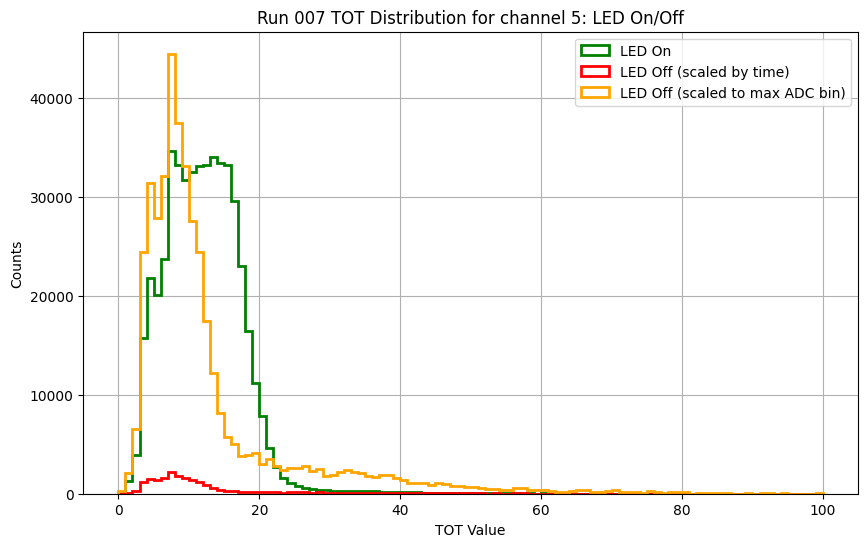

In [14]:
# Histogram the TOT values for the blocks with LED off and with LED on. Rescale the off blocks by the total time duration ratio.
# Execute the previous code cell again to recalculate time_ratio if needed.

hist_bins = 100
hist_range = (0, 100)

# plot the tot distributions for on and off blocks
ic = 0  # channel index to plot
plt.figure(figsize=(10, 6))
# LED on blocks
mask_on = np.zeros_like(tot_values, dtype=bool)
for start, end in zip(block_starts, block_ends):
    mask_on |= (time_coarse_values >= start) & (time_coarse_values <= end)
plt.hist(tot_values[mask_on & (channel_values == channels[ic])], bins=hist_bins, range=hist_range, histtype='step', lw=2, color='green', label='LED On')
# LED off blocks
mask_off = np.zeros_like(tot_values, dtype=bool)
for start, end in zip(off_starts, off_ends):
    mask_off |= (time_coarse_values >= start) & (time_coarse_values <= end)
plt.hist(tot_values[mask_off & (channel_values == channels[ic])], bins=hist_bins, range=hist_range, histtype='step', lw=2, color='red', label='LED Off (scaled by time)', weights=np.full(np.sum(mask_off & (channel_values == channels[ic])), time_ratio))

# Now show the LED off histogram scaled by ratio_max_bin
plt.hist(tot_values[mask_off & (channel_values == channels[ic])], bins=hist_bins, range=hist_range, histtype='step', lw=2, color='orange', label='LED Off (scaled to max ADC bin)', weights=np.full(np.sum(mask_off & (channel_values == channels[ic])), time_ratio * ratio_max_bin))

plt.legend()
#plt.yscale('log')
plt.xlabel('TOT Value')
plt.ylabel('Counts')
plt.title(f'Run {run:03d} TOT Distribution for channel {channels[ic]}: LED On/Off')
plt.grid(True)
plt.savefig(f'img/tot_distribution_on_off_run{run:03d}_chan{channels[ic]:02d}.png')
plt.show()


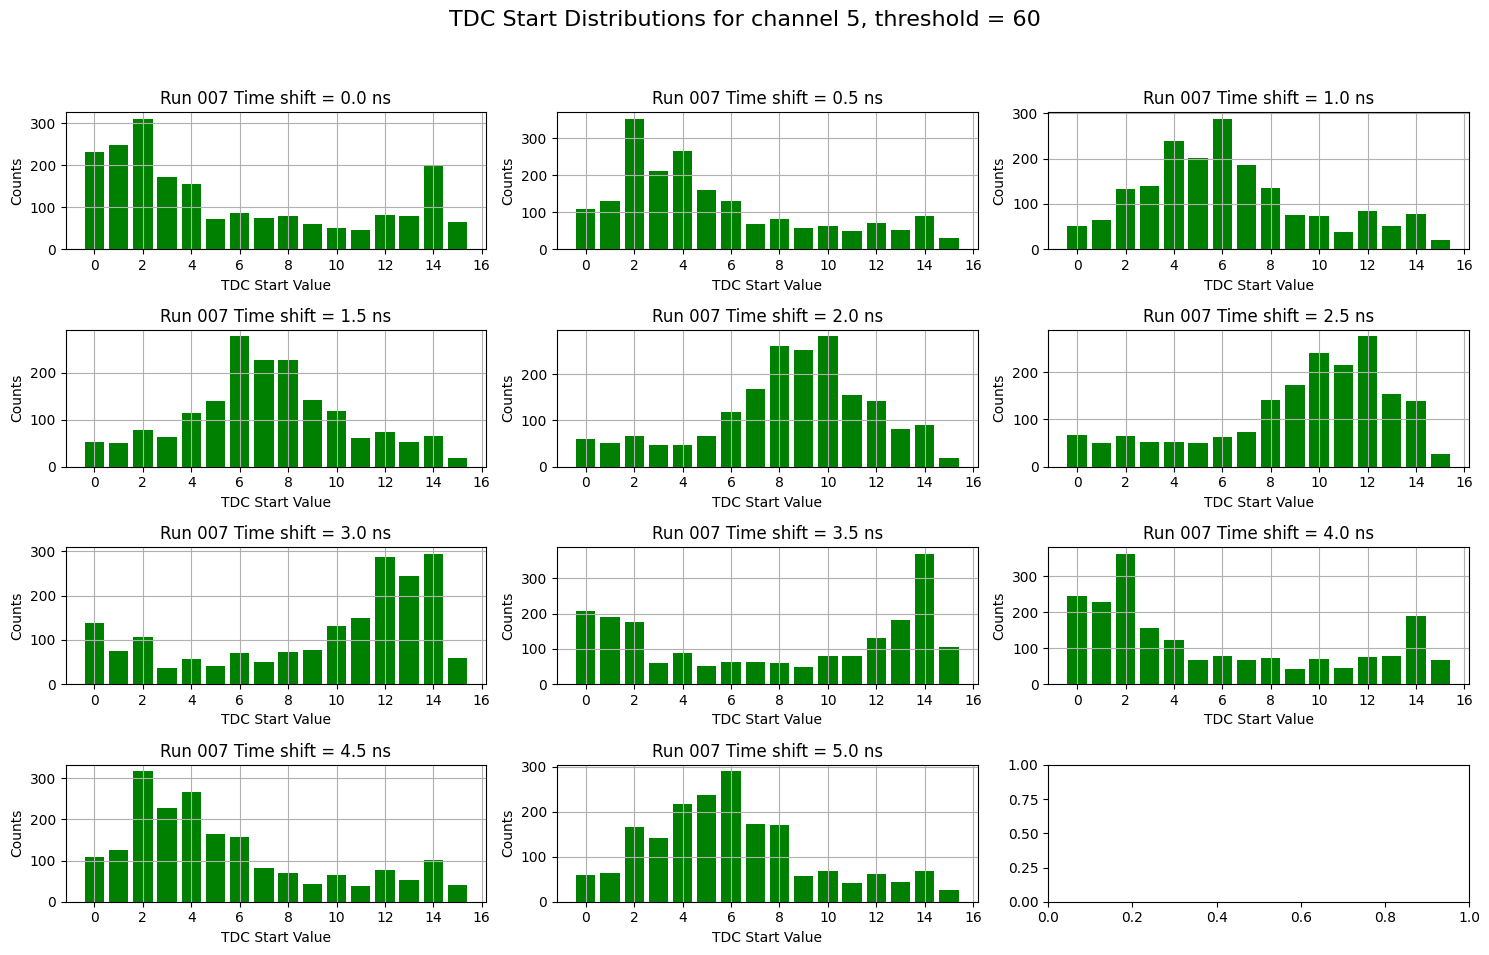

In [15]:
# Show the distribution for tdc_start for entries in each block and adc > 600
# The tdc_start value is a 4 bit number (0 to 15) so we can use 15 bins
# each block in a separate subplot, and offset is the title - be sure to leave some space between the plots

ic = 0  # channel index to plot

fig, axs = plt.subplots(4, 3, figsize=(15, 10))
fig.suptitle(f'TDC Start Distributions for channel {channels[ic]}, threshold = {threshold}', fontsize=16)
axs = axs.flatten()
for i, (start, end) in enumerate(zip(block_starts, block_ends)):
    mask = (time_coarse_values >= start) & (time_coarse_values <= end) & (adc_values > 600) & (channel_values == channels[ic])
    axs[i].hist(tdc_start_values[mask], bins= np.arange(0, 17, 1), color='green', align='left', rwidth=0.8)
    axs[i].set_title(f'Run {run:03d} Time shift = {time_shifts[i]} ns')
    axs[i].set_xlabel('TDC Start Value')
    axs[i].set_ylabel('Counts')
    axs[i].grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f'img/tdc_start_distributions_run{run:03d}_chan{channels[ic]:02d}.png')
plt.show()


Minimum significant modulus: 2266.0, Maximum significant modulus: 2698.0
Difference: 16.0 between 2266.0 and 2282.0
Difference: 16.0 between 2282.0 and 2298.0
Difference: 16.0 between 2298.0 and 2314.0
Difference: 16.0 between 2314.0 and 2330.0
Difference: 16.0 between 2330.0 and 2346.0
Difference: 16.0 between 2346.0 and 2362.0
Difference: 16.0 between 2362.0 and 2378.0
Difference: 16.0 between 2378.0 and 2394.0
Difference: 16.0 between 2394.0 and 2410.0
Difference: 16.0 between 2410.0 and 2426.0
Difference: 16.0 between 2426.0 and 2442.0
Difference: 16.0 between 2442.0 and 2458.0
Difference: 16.0 between 2458.0 and 2474.0
Difference: 16.0 between 2474.0 and 2490.0
Difference: 16.0 between 2490.0 and 2506.0
Difference: 16.0 between 2506.0 and 2522.0
Difference: 16.0 between 2522.0 and 2538.0
Difference: 16.0 between 2538.0 and 2554.0
Difference: 16.0 between 2554.0 and 2570.0
Difference: 16.0 between 2570.0 and 2586.0
Difference: 16.0 between 2586.0 and 2602.0
Difference: 16.0 between

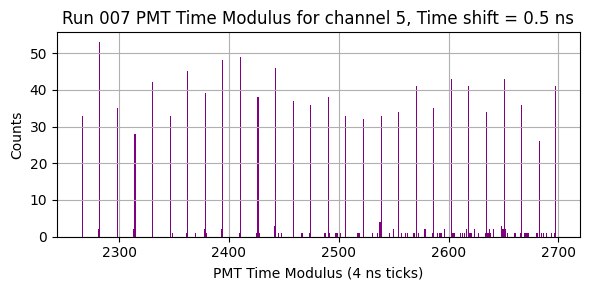

In [16]:
# The distribution of TDC start values shown above are missing the next higher bit
# Use the known period of flashes
clock_period = period / 4  # in units of 4 ns clock ticks that defines the fine time
# choose a block which TDC start values are centered around 8
ic = 0
ib = 1
# find the modulus of pmt_time with respect to the clock period
mask = (time_coarse_values >= block_starts[ib]) & (time_coarse_values <= block_ends[ib]) & (adc_values > 600) & (channel_values == channels[ic])
pmt_time_modulus = pmt_time_values[mask] % clock_period
# find the unique values and their counts
unique, counts = np.unique(pmt_time_modulus, return_counts=True)
# find the values having at least 20 counts and save the minimum and maximum modulus values
mask_count = (counts >= 20)
min_modulus = unique[mask_count][0]
max_modulus = unique[mask_count][-1]
print(f'Minimum significant modulus: {min_modulus}, Maximum significant modulus: {max_modulus}')
for i in range(1, len(unique[mask_count])):
    print(f'Difference: {unique[mask_count][i]-unique[mask_count][i-1]} between {unique[mask_count][i-1]} and {unique[mask_count][i]}')

bins = np.arange(min_modulus-1, max_modulus+1, 1)
# show the distribution of the modulus values over that range
# make the plot have aspect ratio of 2:1
# make sure that the bottom label is not cut off
plt.figure(figsize=(6, 3))
plt.hist(pmt_time_modulus, bins=bins, color='purple')
plt.xlabel('PMT Time Modulus (4 ns ticks)')
plt.ylabel('Counts')
plt.title(f'Run {run:03d} PMT Time Modulus for channel {channels[ic]}, Time shift = {time_shifts[ib]} ns')
plt.grid(True)
plt.tight_layout()
plt.savefig(f'img/pmt_time_modulus_run{run:03d}_chan{channels[ic]:02d}_block{ib}.png')
plt.show()


In [17]:
# Show that there is a bug that adds 64 ns every second to the fine time
# look at the coarse time for the first event in each of these unique modulus values with significant counts
for um in unique[mask_count]:
    sel_coarse_times = time_coarse_values[mask][pmt_time_modulus == um]
    sel_pmt_time_mods = pmt_time_values[mask][pmt_time_modulus == um] % clock_period
    # print the first coarse time and fine time for this modulus value
    first_coarse_time = sel_coarse_times[0]
    first_pmt_time_mod = sel_pmt_time_mods[0]
     # print the modulus value, first coarse time, and first fine time
    print(f'Modulus: {um}, First Coarse Time: {first_coarse_time}, First PMT Time Modulus: {int(first_pmt_time_mod)}')


Modulus: 2266.0, First Coarse Time: 45566, First PMT Time Modulus: 2266
Modulus: 2282.0, First Coarse Time: 45567, First PMT Time Modulus: 2282
Modulus: 2298.0, First Coarse Time: 45568, First PMT Time Modulus: 2298
Modulus: 2314.0, First Coarse Time: 45569, First PMT Time Modulus: 2314
Modulus: 2330.0, First Coarse Time: 45566, First PMT Time Modulus: 2330
Modulus: 2346.0, First Coarse Time: 45571, First PMT Time Modulus: 2346
Modulus: 2362.0, First Coarse Time: 45572, First PMT Time Modulus: 2362
Modulus: 2378.0, First Coarse Time: 45573, First PMT Time Modulus: 2378
Modulus: 2394.0, First Coarse Time: 45574, First PMT Time Modulus: 2394
Modulus: 2410.0, First Coarse Time: 45575, First PMT Time Modulus: 2410
Modulus: 2426.0, First Coarse Time: 45576, First PMT Time Modulus: 2426
Modulus: 2442.0, First Coarse Time: 45577, First PMT Time Modulus: 2442
Modulus: 2458.0, First Coarse Time: 45567, First PMT Time Modulus: 2458
Modulus: 2474.0, First Coarse Time: 45579, First PMT Time Modulu

In [18]:
# The bug can be removed by subtracting 16 from the fine time for every increment of the time_coarse
# Find the lowest coarse time in the dataset that has adc > threshold
ic = 0
mask = (adc_values > threshold) & (channel_values == channels[ic])
min_coarse_time = np.min(time_coarse_values[mask])
print(f'Minimum coarse time with adc > {threshold}: {min_coarse_time}')
# create a corrected pmt_time array
corrected_pmt_time_values = pmt_time_values - 16 * (time_coarse_values - min_coarse_time)

Minimum coarse time with adc > 60: 45433


Minimum significant modulus: 138.0, Maximum significant modulus: 139.0
Difference: 1.0 between 138.0 and 139.0


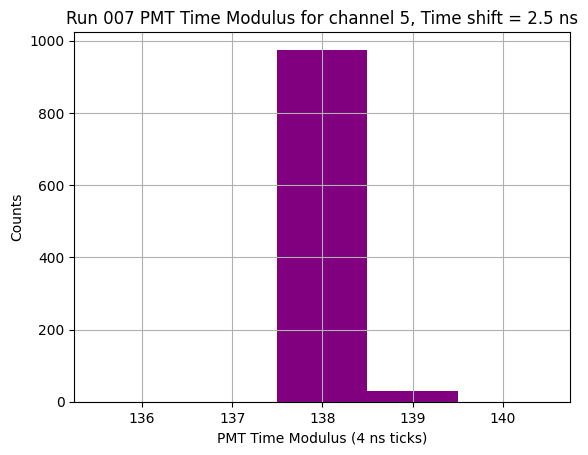

In [19]:
# The distribution of TDC start values shown above are missing the next higher bit
# Use the known period of flashes
clock_period = period / 4  # in units of 4 ns clock ticks that defines the fine time
# choose a block which TDC start values are centered around 8
ic = 0
ib = 5
# find the modulus of pmt_time with respect to the clock period
mask = (time_coarse_values >= block_starts[ib]) & (time_coarse_values <= block_ends[ib]) & (adc_values > 600) & (channel_values == channels[ic])
pmt_time_modulus = corrected_pmt_time_values[mask] % clock_period
# find the unique values and their counts
unique, counts = np.unique(pmt_time_modulus, return_counts=True)
# find the values having at least 20 counts and save the minimum and maximum modulus values
mask_count = (counts >= 20)
min_modulus = unique[mask_count][0]
max_modulus = unique[mask_count][-1]
print(f'Minimum significant modulus: {min_modulus}, Maximum significant modulus: {max_modulus}')
for i in range(1, len(unique[mask_count])):
    print(f'Difference: {unique[mask_count][i]-unique[mask_count][i-1]} between {unique[mask_count][i-1]} and {unique[mask_count][i]}')

# choose the modulus with the most events
selected_pmt_time_modulus = unique[np.argmax(counts)]

bins = np.arange(selected_pmt_time_modulus-2, selected_pmt_time_modulus+4, 1)
# show the distribution of the modulus values over that range
plt.hist(pmt_time_modulus, bins=bins, color='purple', align='left')
plt.xlabel('PMT Time Modulus (4 ns ticks)')
plt.ylabel('Counts')
plt.title(f'Run {run:03d} PMT Time Modulus for channel {channels[ic]}, Time shift = {time_shifts[ib]} ns')
plt.grid(True)
plt.savefig(f'img/corrected_pmt_time_modulus_run{run:03d}_chan{channels[ic]:02d}_block{ib}.png')
plt.show()


In [20]:
# Show that there is a bug that adds 64 ns every second to the fine time
# look at the coarse time for the first event in each of these unique modulus values with significant counts
# Sometimes there are a few entries far away from the main cluster (in run 6 that occurs at ib = 0 and 1)
for um in unique[mask_count]:
    sel_coarse_times = time_coarse_values[mask][pmt_time_modulus == um]
    sel_pmt_time_mods = corrected_pmt_time_values[mask][pmt_time_modulus == um] % clock_period
    sel_adcs = adc_values[mask][pmt_time_modulus == um]
    # print the first coarse time and fine time for this modulus value
    first_coarse_time = sel_coarse_times[0]
    first_pmt_time_mod = sel_pmt_time_mods[0]
     # print the modulus value, first coarse time, and first fine time
    print(f'Modulus: {um}, First Coarse Time: {first_coarse_time}, First PMT Time Modulus: {int(first_pmt_time_mod)}, number of entries: {len(sel_coarse_times)}, mean adc: {np.mean(sel_adcs)}')

Modulus: 138.0, First Coarse Time: 45760, First PMT Time Modulus: 138, number of entries: 975, mean adc: 646.628717948718
Modulus: 139.0, First Coarse Time: 45760, First PMT Time Modulus: 139, number of entries: 29, mean adc: 627.4137931034483


In [21]:
# Count the number of flashes seen in the data compared to the number of function generator pulses
# make a table showing for each block:
# time_shift, duration, # pulses, # signals, f_0, and E[Npe]
ic = 0

print(f"| {'Time Shift (ns)':>15} | {'Duration (s)':>10} | {'# Pulses':>10} | {'# Signals':>10} | {'f0':>17} | {'E[Npe]':>15} |")
print('|------'*6 + '|')
enpnes = []
for ib in range(len(block_starts)):
    mask = (time_coarse_values >= block_starts[ib]) & (time_coarse_values <= block_ends[ib]) & (adc_values > threshold) & (channel_values == channels[ic])
    pmt_time_modulus_zeroed = corrected_pmt_time_values[mask] % clock_period - selected_pmt_time_modulus
    all_signal_times = pmt_time_modulus_zeroed * 4 + tdc_start_values[mask]/4.  # in ns
    signal_times = all_signal_times[(-50 < all_signal_times) & (all_signal_times < 50)]
    num_signals = len(signal_times)
    first_corrected_pmt_time = np.min(corrected_pmt_time_values[mask][(-50 < all_signal_times) & (all_signal_times < 50)])
    last_corrected_pmt_time = np.max(corrected_pmt_time_values[mask][(-50 < all_signal_times) & (all_signal_times < 50)])
    duration_ns = (last_corrected_pmt_time - first_corrected_pmt_time) * 4  # in ns
    num_pulses = duration_ns / period
    fraction_no_signal = (num_pulses - num_signals) / num_pulses if num_pulses > 0 else 0
    npe_expected = -np.log(fraction_no_signal) if fraction_no_signal > 0 else float('inf')
#    print(f'Block {ib}: Time shift = {time_shifts[ib]} ns, # signals = {num_signals}, # fg pulses = {num_pulses:.1f}, Duration = {duration_ns/1e9:.2f} s, Fraction with no signal = {fraction_no_signal:.3f}, Npe expected = {npe_expected:.2f}')
    print(f'| {time_shifts[ib]:15.2f} | {duration_ns/1e9:10.2f} | {num_pulses:10.1f} | {num_signals:10d} | {fraction_no_signal:17.4f} | {npe_expected:15.3f} |')
    enpnes.append(npe_expected)

# print the mean and standard deviation of the npe_expected values
mean_enpe = np.mean(enpnes)
std_enpe = np.std(enpnes)

print()
print(f' * Mean E[Npe]: {mean_enpe:.3f}, Std E[Npe]: {std_enpe:.3f}')
# Print ratio of Poisson probabilities for n=1,2,3,4,5 divided by the probability for n>0 on one line
print(" * Poisson probabilities for (n=1 to 5) for signals (ie. n>0):")
buff = []
for n in range(1, 6):
    prob_n = (mean_enpe**n / np.math.factorial(n)) * np.exp(-mean_enpe)
    prob_gt0 = 1 - np.exp(-mean_enpe)
    ratio = prob_n / prob_gt0 if prob_gt0 > 0 else 0
    buff.append(f"n={n}: {ratio:.4f}")
print(' * ' + ', '.join(buff))


| Time Shift (ns) | Duration (s) |   # Pulses |  # Signals |                f0 |          E[Npe] |
|------|------|------|------|------|------|
|            0.00 |      32.21 |   322109.0 |      43601 |            0.8646 |           0.145 |
|            0.50 |      30.06 |   300617.0 |      40644 |            0.8648 |           0.145 |
|            1.00 |      30.06 |   300642.0 |      40145 |            0.8665 |           0.143 |
|            1.50 |      28.99 |   289903.0 |      38742 |            0.8664 |           0.143 |
|            2.00 |      31.14 |   311357.0 |      42044 |            0.8650 |           0.145 |
|            2.50 |      31.14 |   311372.0 |      41508 |            0.8667 |           0.143 |
|            3.00 |      30.06 |   300618.0 |      40064 |            0.8667 |           0.143 |
|            3.50 |      32.21 |   322103.0 |      42735 |            0.8673 |           0.142 |
|            4.00 |      31.14 |   311363.0 |      41123 |            0.8679 |   

## Run 006

| Time Shift (ns) | Duration (s) |   # Pulses |  # Signals |                f0 |          E[Npe] |
|------|------|------|------|------|------|
|            0.00 |       7.52 |    75160.0 |      74768 |            0.0052 |           5.256 |
|            0.50 |       5.37 |    53686.0 |      53394 |            0.0054 |           5.214 |
|            1.00 |       7.52 |    75161.0 |      74754 |            0.0054 |           5.219 |
|            1.50 |       6.44 |    64423.0 |      64041 |            0.0059 |           5.128 |
|            2.00 |       5.37 |    53686.0 |      53384 |            0.0056 |           5.180 |
|            2.50 |       7.52 |    75161.0 |      74742 |            0.0056 |           5.190 |
|            3.00 |       5.37 |    53686.0 |      53359 |            0.0061 |           5.101 |
|            3.50 |       4.29 |    42949.0 |      42705 |            0.0057 |           5.171 |
|            4.00 |       6.44 |    64424.0 |      64073 |            0.0054 |           5.212 |
|            4.50 |       5.37 |    53686.0 |      53378 |            0.0057 |           5.161 |
|            5.00 |       6.44 |    64424.0 |      64028 |            0.0061 |           5.092 |

 * Mean E[Npe]: 5.175, Std E[Npe]: 0.049
 * Poisson probabilities for (n=1 to 5) for signals (ie. n>0):
 * n=1: 0.0294, n=2: 0.0762, n=3: 0.1314, n=4: 0.1700, n=5: 0.1759

## Run 007

| Time Shift (ns) | Duration (s) |   # Pulses |  # Signals |                f0 |          E[Npe] |
|------|------|------|------|------|------|
|            0.00 |      32.21 |   322109.0 |      43601 |            0.8646 |           0.145 |
|            0.50 |      30.06 |   300617.0 |      40644 |            0.8648 |           0.145 |
|            1.00 |      30.06 |   300642.0 |      40145 |            0.8665 |           0.143 |
|            1.50 |      28.99 |   289903.0 |      38742 |            0.8664 |           0.143 |
|            2.00 |      31.14 |   311357.0 |      42044 |            0.8650 |           0.145 |
|            2.50 |      31.14 |   311372.0 |      41508 |            0.8667 |           0.143 |
|            3.00 |      30.06 |   300618.0 |      40064 |            0.8667 |           0.143 |
|            3.50 |      32.21 |   322103.0 |      42735 |            0.8673 |           0.142 |
|            4.00 |      31.14 |   311363.0 |      41123 |            0.8679 |           0.142 |
|            4.50 |      31.14 |   311384.0 |      41523 |            0.8667 |           0.143 |
|            5.00 |      30.06 |   300629.0 |      39626 |            0.8682 |           0.141 |

 * Mean E[Npe]: 0.143, Std E[Npe]: 0.001
 * Poisson probabilities for (n=1 to 5) for signals (ie. n>0):
 * n=1: 0.9300, n=2: 0.0667, n=3: 0.0032, n=4: 0.0001, n=5: 0.0000

## Run 008

| Time Shift (ns) | Duration (s) |   # Pulses |  # Signals |                f0 |          E[Npe] |
|------|------|------|------|------|------|
|            0.00 |      21.47 |   214747.0 |     108296 |            0.4957 |           0.702 |
|            0.50 |      19.33 |   193271.0 |      95686 |            0.5049 |           0.683 |
|            1.00 |      20.40 |   204010.0 |     101313 |            0.5034 |           0.686 |
|            1.50 |      21.47 |   214745.0 |     106572 |            0.5037 |           0.686 |
|            2.00 |      20.40 |   204000.0 |     101088 |            0.5045 |           0.684 |
|            2.50 |      20.40 |   204004.0 |     100538 |            0.5072 |           0.679 |
|            3.00 |      21.47 |   214745.0 |     105880 |            0.5070 |           0.679 |
|            3.50 |      20.40 |   204008.0 |      99909 |            0.5103 |           0.673 |
|            4.00 |      18.25 |   182533.0 |      89862 |            0.5077 |           0.678 |
|            4.50 |      21.47 |   214746.0 |     105055 |            0.5108 |           0.672 |
|            5.00 |      20.40 |   204006.0 |      99633 |            0.5116 |           0.670 |

 * Mean E[Npe]: 0.681, Std E[Npe]: 0.008
 * Poisson probabilities for (n=1 to 5) for signals (ie. n>0):
 * n=1: 0.6978, n=2: 0.2376, n=3: 0.0540, n=4: 0.0092, n=5: 0.0013
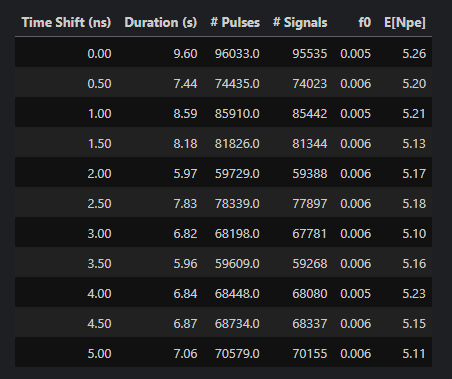

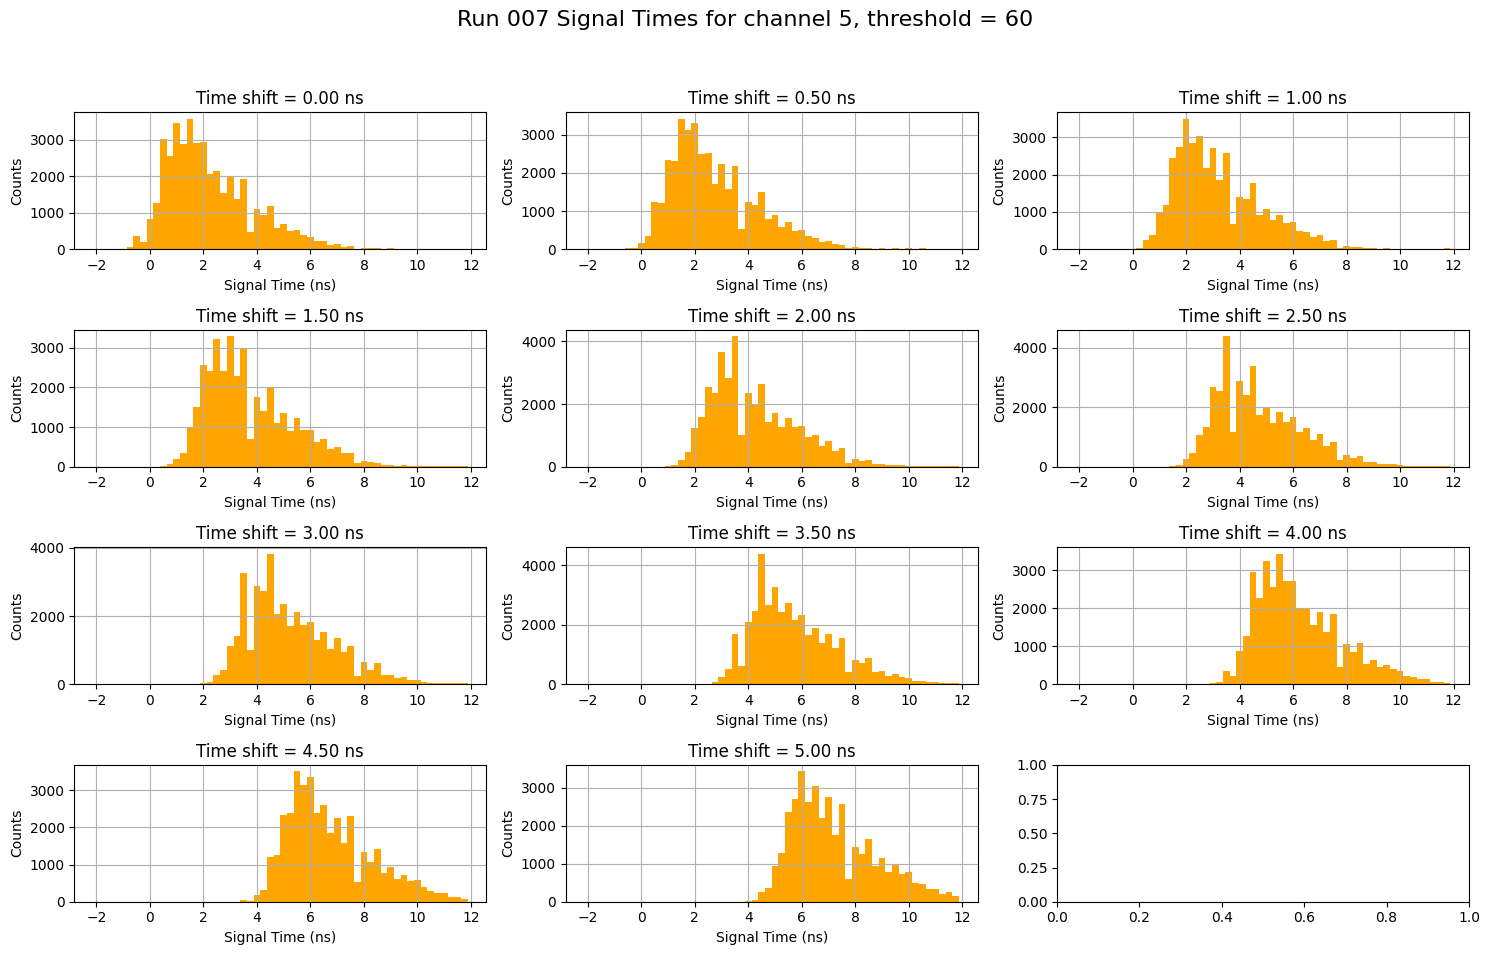

In [22]:
# Now we can look at the full timing of the signals, modulus the 100 us period of the LED flashes
# We will use the corrected pmt_time values
# Show the distributions for each block in a separate subplot
signal_times_by_blocks = []
ic = 0  # channel index to plot
fig, axs = plt.subplots(4, 3, figsize=(15, 10))
fig.suptitle(f'Run {run:03d} Signal Times for channel {channels[ic]}, threshold = {threshold}', fontsize=16)
axs = axs.flatten()
for i, (start, end) in enumerate(zip(block_starts, block_ends)):
    mask = (time_coarse_values >= start) & (time_coarse_values <= end) & (adc_values > threshold) & (channel_values == channels[ic])
    pmt_time_modulus_zeroed = corrected_pmt_time_values[mask] % clock_period - selected_pmt_time_modulus
    signal_times = pmt_time_modulus_zeroed * 4 + tdc_start_values[mask]/4.  # in ns
    signal_times = signal_times[(-50 < signal_times) & (signal_times < 50)]  # keep only times within -50 to 50 ns
    signal_times_by_blocks.append(signal_times)
    axs[i].hist(signal_times, bins= np.arange(-2., 12.25, 0.25), color='orange', align='left')
    axs[i].set_title(f'Time shift = {time_shifts[i]:.2f} ns')
    axs[i].set_xlabel('Signal Time (ns)')
    axs[i].set_ylabel('Counts')
    axs[i].grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f'img/signal_times_run{run:03d}_chan{channels[ic]:02d}.png')
plt.show()

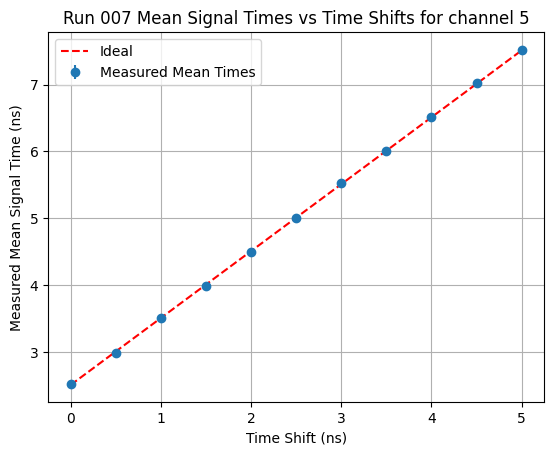

In [23]:
# Look at the response based on mean and RMS of each block
mean_times = [np.mean(st) for st in signal_times_by_blocks]
rms_times = [np.std(st) for st in signal_times_by_blocks]
error_times = [rms/np.sqrt(len(st)) for rms, st in zip(rms_times, signal_times_by_blocks)]
# find offsets with respect to the time_shifts
offsets_measured = [mean_times[i] - time_shifts[i] for i in range(len(mean_times))]
mean_offset = np.mean(offsets_measured)

# plot the mean times with error bars
plt.errorbar(time_shifts, mean_times, yerr=error_times, fmt='o', label='Measured Mean Times')
# plot the ideal line
plt.plot(time_shifts, time_shifts + mean_offset, 'r--', label='Ideal')
plt.xlabel('Time Shift (ns)')
plt.ylabel('Measured Mean Signal Time (ns)')
plt.title(f'Run {run:03d} Mean Signal Times vs Time Shifts for channel {channels[ic]}')
plt.legend()
plt.grid(True)
plt.savefig(f'img/mean_signal_times_run{run:03d}_chan{channels[ic]:02d}.png')
plt.show()

In [24]:
# print summary:
print(f"Mean offset (measured - ideal): {mean_offset:.2f} ns")
print(f"Mean of RMS values: {np.mean(rms_times):.2f} ns")
print("Time Shift (ns) | Measured Mean Time (ns) | RMS (ns) | Number of Entries")
for i in range(len(mean_times)):
    print(f"{time_shifts[i]:15.2f} | {mean_times[i]:22.2f} | {rms_times[i]:7.2f} | {len(signal_times_by_blocks[i]):17d}")


Mean offset (measured - ideal): 2.51 ns
Mean of RMS values: 2.90 ns
Time Shift (ns) | Measured Mean Time (ns) | RMS (ns) | Number of Entries
           0.00 |                   2.53 |    2.97 |             43601
           0.50 |                   2.98 |    2.79 |             40644
           1.00 |                   3.52 |    2.95 |             40145
           1.50 |                   3.98 |    2.85 |             38742
           2.00 |                   4.50 |    2.91 |             42044
           2.50 |                   5.01 |    2.92 |             41508
           3.00 |                   5.53 |    2.94 |             40064
           3.50 |                   6.00 |    2.86 |             42735
           4.00 |                   6.51 |    2.90 |             41123
           4.50 |                   7.02 |    2.88 |             41523
           5.00 |                   7.52 |    2.93 |             39626


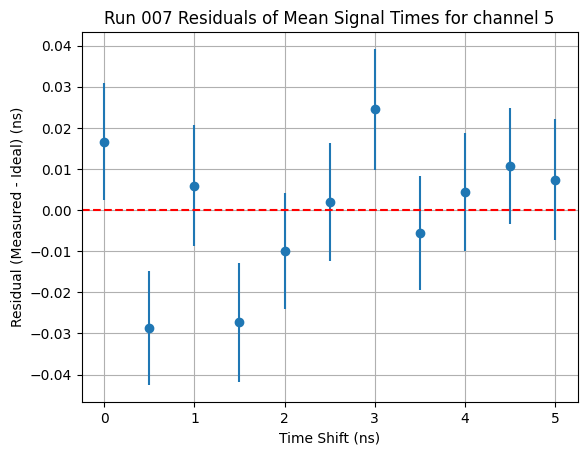

In [25]:
# Look at the residual between measured and ideal
residuals = [mean_times[i] - (time_shifts[i] + mean_offset) for i in range(len(mean_times))]
plt.errorbar(time_shifts, residuals, yerr=error_times, fmt='o')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Time Shift (ns)')
plt.ylabel('Residual (Measured - Ideal) (ns)')
plt.title(f'Run {run:03d} Residuals of Mean Signal Times for channel {channels[ic]}')
plt.grid(True)
plt.savefig(f'img/residuals_signal_times_run{run:03d}_chan{channels[ic]:02d}.png')
plt.show()

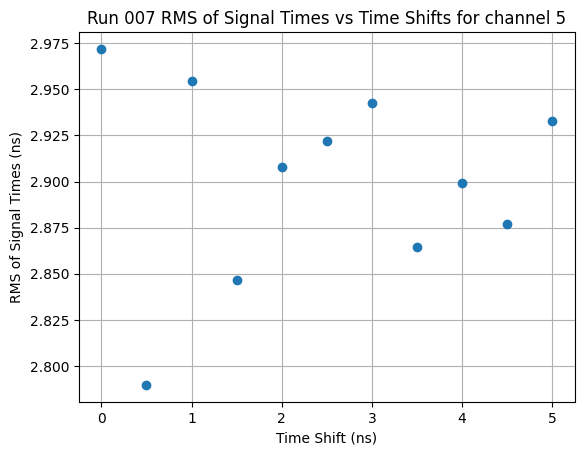

In [26]:
# Show the RMS values vs time shifts
plt.plot(time_shifts, rms_times, 'o')
plt.xlabel('Time Shift (ns)')
plt.ylabel('RMS of Signal Times (ns)')
plt.title(f'Run {run:03d} RMS of Signal Times vs Time Shifts for channel {channels[ic]}')
plt.grid(True)
plt.savefig(f'img/rms_signal_times_run{run:03d}_chan{channels[ic]:02d}.png')
plt.show()

Number of in-window signals: 435457, Number of out-of-window signals: 55373, afterpulse fraction: 0.1272


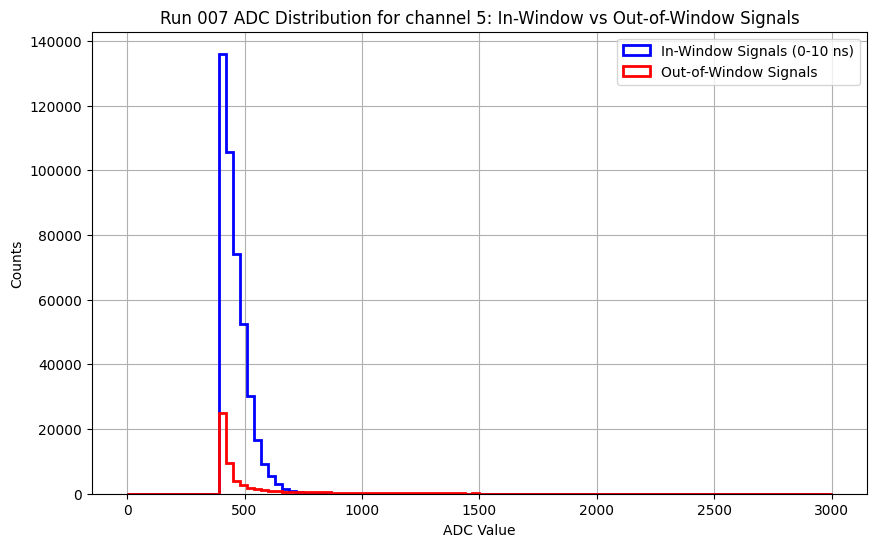

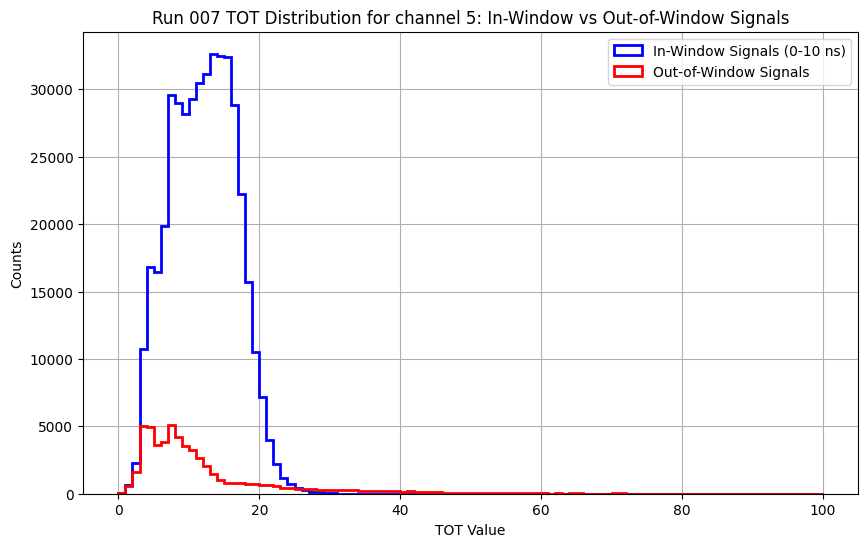

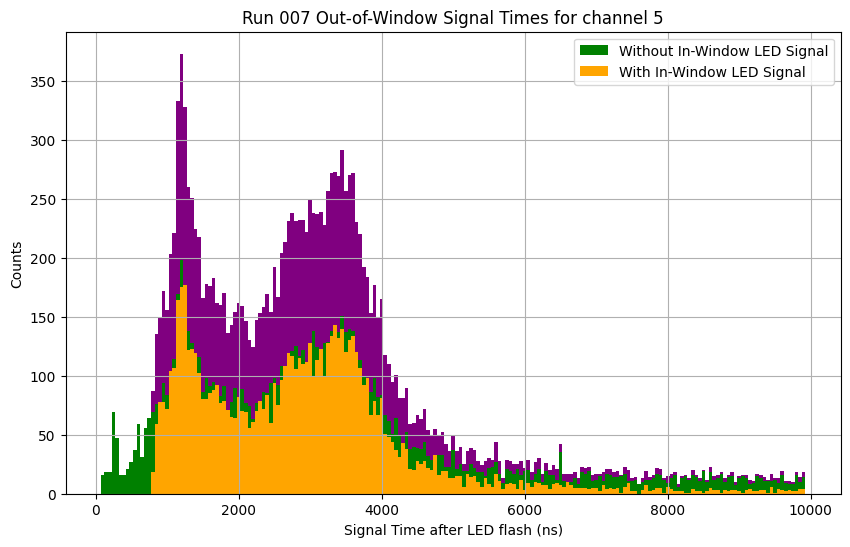

In [33]:
# Make two histograms showing the distributions of ADC and TOT for LED ON periods for signals within 0-10 ns of the expected flash time and for those outside that window
# Use the corrected pmt_time values

# Define the signal window
signal_window_ns = 10  # ns
hist_bins_adc = 100
hist_range_adc = (0, 3000)
hist_bins_tot = 100
hist_range_tot = (0, 100)

in_window_adc = np.array([])
in_window_tot = np.array([])
out_window_adc = np.array([])
out_window_tot = np.array([])
out_window_signal_times = np.array([])
in_window_pmt_flash_counters = np.array([])
for i, (start, end) in enumerate(zip(block_starts, block_ends)):
    mask = (time_coarse_values >= start) & (time_coarse_values <= end) & (channel_values == channels[ic])
    pmt_time_modulus_zeroed = corrected_pmt_time_values[mask] % clock_period - selected_pmt_time_modulus
    signal_times = pmt_time_modulus_zeroed * 4 + tdc_start_values[mask]/4.  # in ns
    in_window_adc = np.append(in_window_adc, adc_values[mask][(0 < signal_times) & (signal_times < 10)])
    out_window_adc = np.append(out_window_adc, adc_values[mask][~((0 < signal_times) & (signal_times < 10))])
    in_window_tot = np.append(in_window_tot, tot_values[mask][(0 < signal_times) & (signal_times < 10)])
    out_window_tot = np.append(out_window_tot, tot_values[mask][~((0 < signal_times) & (signal_times < 10))])
    out_window_signal_times = np.append(out_window_signal_times, signal_times[~((0 < signal_times) & (signal_times < 10))])
    in_window_pmt_flash_counters = np.append(in_window_pmt_flash_counters, (corrected_pmt_time_values[mask] // clock_period)[(0 < signal_times) & (signal_times < 10)])

out_window_signal_times_w_led_signal = []
out_window_signal_times_wo_led_signal = []
for i, (start, end) in enumerate(zip(block_starts, block_ends)):
    mask = (time_coarse_values >= start) & (time_coarse_values <= end) & (channel_values == channels[ic])
    pmt_time_modulus_zeroed = corrected_pmt_time_values[mask] % clock_period - selected_pmt_time_modulus
    signal_times = pmt_time_modulus_zeroed * 4 + tdc_start_values[mask]/4.  # in ns
    in_window_pmt_flash_counter = corrected_pmt_time_values[mask] // clock_period
    with_led_signal = np.unique(in_window_pmt_flash_counters)
    for st, iwpfc in zip(signal_times,in_window_pmt_flash_counter):
        if (st < 0) or (st > 10):
            if iwpfc in in_window_pmt_flash_counters:
                out_window_signal_times_w_led_signal.append(st)
            else:
                out_window_signal_times_wo_led_signal.append(st)


print(f'Number of in-window signals: {len(in_window_adc)}, Number of out-of-window signals: {len(out_window_adc)}, afterpulse fraction: {len(out_window_adc)/len(in_window_adc):.4f}')

# plot the adc distributions for in-window and out-of-window signals
ic = 0  # channel index to plot
plt.figure(figsize=(10, 6))

# In-window signals
plt.hist(in_window_adc, bins=hist_bins_adc, range=hist_range_adc, histtype='step', lw=2, color='blue', label='In-Window Signals (0-10 ns)')
# Out-of-window signals
plt.hist(out_window_adc, bins=hist_bins_adc, range=hist_range_adc, histtype='step', lw=2, color='red', label='Out-of-Window Signals')

plt.legend()
#plt.yscale('log')
plt.xlabel('ADC Value')
plt.ylabel('Counts')
plt.title(f'Run {run:03d} ADC Distribution for channel {channels[ic]}: In-Window vs Out-of-Window Signals')
plt.grid(True)
plt.savefig(f'img/adc_distribution_in_out_window_run{run:03d}_chan{channels[ic]:02d}.png')
plt.show()
# plot the tot distributions for in-window and out-of-window signals

plt.figure(figsize=(10, 6))
# In-window signals
plt.hist(in_window_tot, bins=hist_bins_tot, range=hist_range_tot, histtype='step', lw=2, color='blue', label='In-Window Signals (0-10 ns)')
# Out-of-window signals
plt.hist(out_window_tot, bins=hist_bins_tot, range=hist_range_tot, histtype='step', lw=2, color='red', label='Out-of-Window Signals')
plt.legend()
#plt.yscale('log')
plt.xlabel('TOT Value')
plt.ylabel('Counts')
plt.title(f'Run {run:03d} TOT Distribution for channel {channels[ic]}: In-Window vs Out-of-Window Signals')
plt.grid(True)
plt.savefig(f'img/tot_distribution_in_out_window_run{run:03d}_chan{channels[ic]:02d}.png')
plt.show()

# plot the signal time distribution for out-of-window signals (in 1000 ns bins)
plt.figure(figsize=(10, 6))
plt.hist(out_window_signal_times, bins= np.arange(100, 10000, 50), color='purple', align='left')
# also plot the out-of-window signals separated by whether there was an in-window signal for that flash
plt.hist(out_window_signal_times_wo_led_signal, bins= np.arange(100, 10000, 50), color='green', align='left', alpha=1., label='Without In-Window LED Signal')
plt.hist(out_window_signal_times_w_led_signal, bins= np.arange(100, 10000, 50), color='orange', align='left', alpha=1., label='With In-Window LED Signal')
plt.legend()
#plt.yscale('log')
plt.xlabel('Signal Time after LED flash (ns)')
plt.ylabel('Counts')
plt.title(f'Run {run:03d} Out-of-Window Signal Times for channel {channels[ic]}')
plt.grid(True)
plt.savefig(f'img/out_window_signal_times_run{run:03d}_chan{channels[ic]:02d}.png')
plt.show()

In [28]:
# make a dictionary with adc, corrected_pmt_time, tdc_start for entries
# save into a pickle file for later use
import pickle

amplitudes = [av for av in adc_values]
clock_counts = [cptv for cptv in corrected_pmt_time_values]
deltas = [tsv for tsv in tdc_start_values]

data_dict = {
    'amplitudes': amplitudes,
    'clock_counts': clock_counts,
    'deltas': deltas
}

with open(f'run{run:03d}_data.pkl', 'wb') as f:
    pickle.dump(data_dict, f)
